# Ejercicio en clase

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import corner

np.random.seed(4)
plt.style.use('fivethirtyeight')

1.- Usa tu código de metropolis para encontrar la pendiente y ordenada al órigen del conjunto de datos en el archivo fit_excercise.npy. El archivo son 3 arreglos que corresponden a x,y,yerror.

In [49]:
file = np.load('fit_ejercise.npy')

In [50]:
x = file[0]
y = file[1]
yerror = file[2]

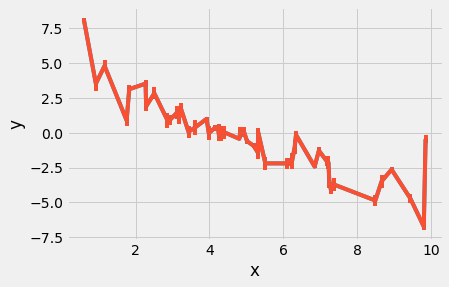

In [51]:
plt.plot(x, y)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

In [52]:
def function(x0, a0, b0):
    return a0*x0 + b0

def likelihood(a, b, data):
    equis = data[0]
    ye = data[1]
    yerr = data[2] 
    model = function(equis, a, b)
    likelihood_0 = (ye-model)**2/(yerr**2)
    return likelihood_0.sum()

In [53]:
rango = 3000

a0 = -3
b0 = 4
lnlike0 = -1*likelihood(a0, b0, [x,y,yerror])

a_sample = [a0]
b_sample = [b0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
    b_new = np.random.normal(b_sample[len(a_sample)-1], sigma)
    like = -1*likelihood(a_new, b_new, [x,y,yerror])
    if like>lnlike0:
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)
    elif lnlike0-like<-math.log(random.uniform(0,1)):
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)

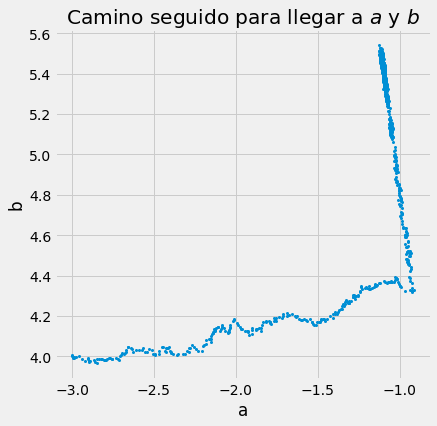

In [54]:
plt.figure(figsize = (6,6))
plt.plot(a_sample,b_sample, 'o', markersize = 2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $a$ y $b$')
plt.grid('True')

In [55]:
len(a_sample)

1428

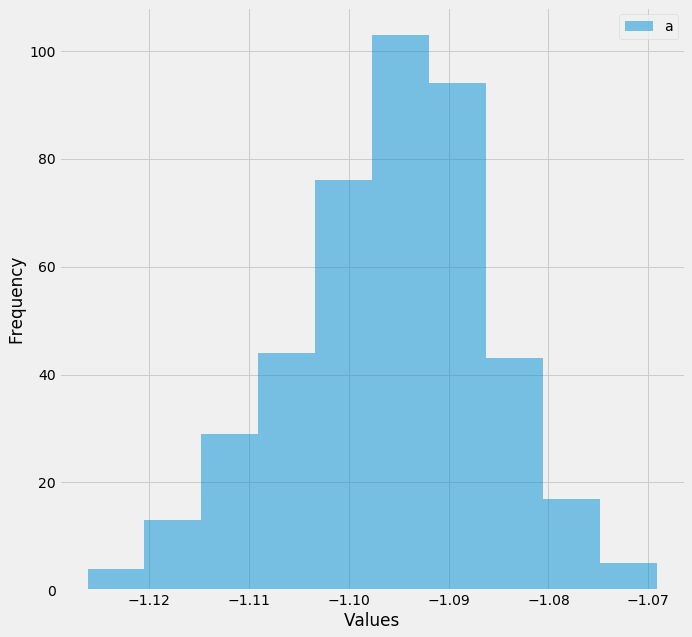

In [56]:
plt.figure(figsize = (10,10))
plt.hist(a_sample[1000: 2000], label = 'a',alpha=0.5);
plt.grid('True')
plt.xlabel('Values')
plt.legend()
plt.ylabel('Frequency');

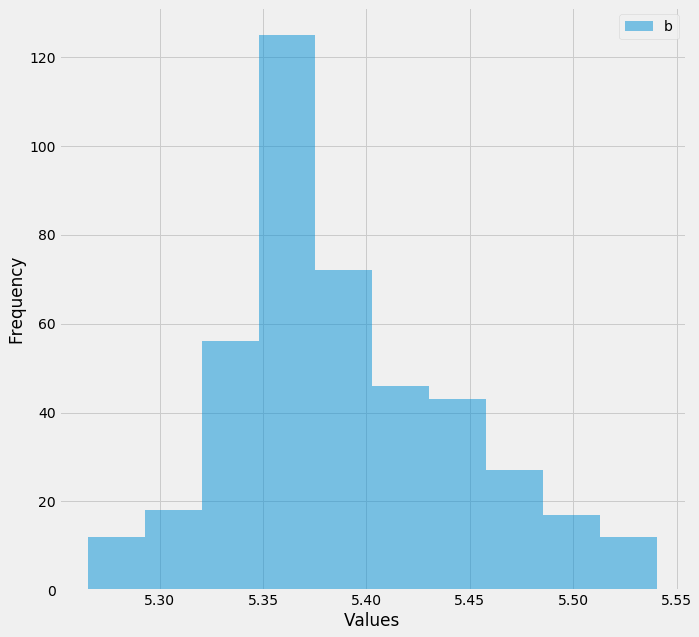

In [57]:
plt.figure(figsize = (10,10))
plt.hist(b_sample[1000: 2000], label = 'b',alpha=0.5);
plt.grid('True')
plt.xlabel('Values')
plt.legend()
plt.ylabel('Frequency');

2.-Grafica tu modelo contra los datos. ¿Qué tan bueno es el ajuste? ¿Cualitativamente? ¿Cuantitativamente?

Calculamos la mediana.

In [58]:
a_great = np.median(np.array(a_sample))
a_great

-1.1004770620561057

In [59]:
b_great = np.median(np.array(b_sample))
b_great

5.369548739294697

In [60]:
x_new = np.linspace(0,10,100)
y_new = a_great*x_new + b_great

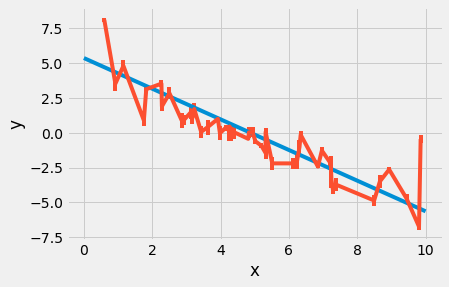

In [61]:
plt.plot(x_new, y_new)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

**Cualitativamente**: Se observa que se ajusta a los datos, ya que la pendiente y la ordenada hacen que la recta esté entre los datos. 

**Cuantitativamente**: ¿Cómo podemos expresar qué tan bien se ajustan nuestros datos a la recta?


Varios caminos:

In [62]:
a_total = []
b_total = []

sigma = 0.01
rango = 2500

for k in range(10):   
    a0 = np.random.normal(-2, 2, 10)
    b0 = np.random.normal(4, 2, 10)
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], [x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, [x,y,yerror])
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
    a_total.append(a_sample)
    b_total.append(b_sample)

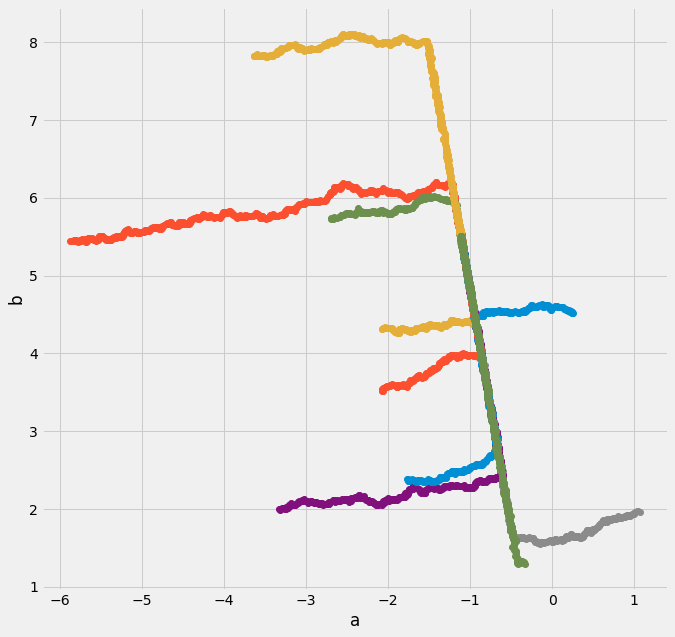

In [63]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.plot(a_total[i], b_total[i], 'o');
plt.grid('True')
plt.xlabel('a')
plt.ylabel('b');

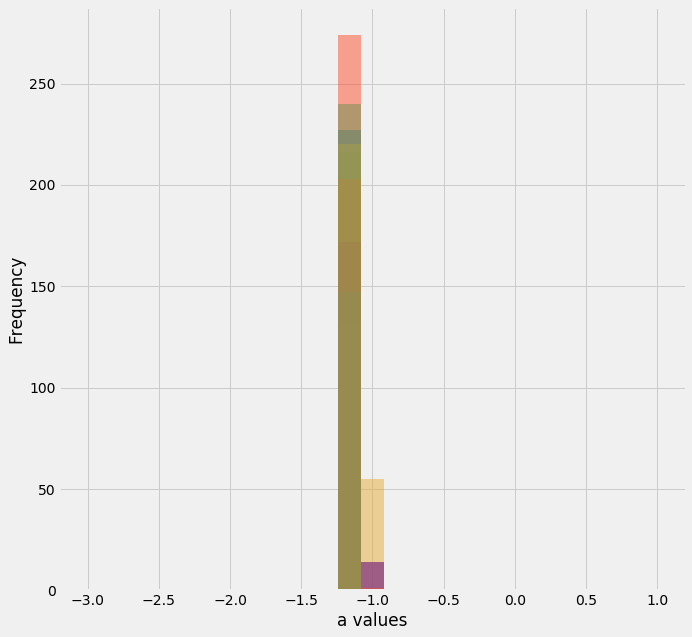

In [64]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i][950:2500], 25, range = (-3,1), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

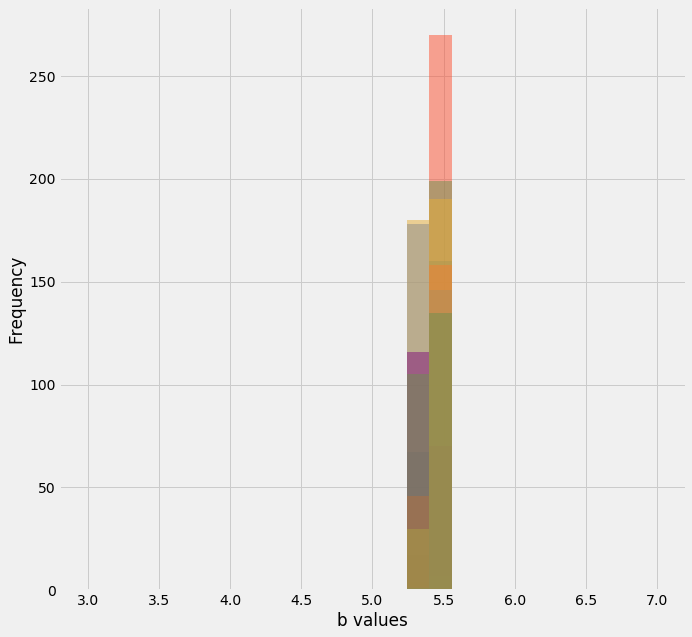

In [65]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i][950:2500], 25, range = (3,7), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

In [66]:
suma = 0
sumb = 0
for i in range(10):
    suma = suma + np.median(a_total[i])
    sumb = sumb + np.median(b_total[i])

In [67]:
suma/10

-1.0843270455179341

In [68]:
sumb/10

5.136320857842994

3.- Usa el método de Gelman-Rubin para determinar si tus cadenas han convergido.Referencia: https://arxiv.org/pdf/1812.09384.pdf 


In [69]:
n = 10
m = 500

def prom_x_i(x_it):
    return np.mean(x_it)

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i])
    return sum/n

def s_i2(x_it):
    return np.std(x_it)

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i])
    return sum/n

def B_n(x_i):
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m):
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [70]:
R(a_total, len(a_total[0]))

1.1925218150577381

In [71]:
R(b_total, len(b_total[0]))

1.3842664056776206

**Nota:** Podríamos concluir que el parámetro $a$ es aceptable debido a Ra. Pero Rb no es tan bueno.

Cambiamos un poco nuestros códigos para mejorar Ra y Rb.

In [72]:
a_total = []
b_total = []

sigma = 0.01
rango = 2500

a0 = np.random.normal(-0.8, 1, 10)
b0 = np.random.normal(4, 0.5, 10)
for k in range(10):   
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], [x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, [x,y,yerror])
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
    a_total.append(a_sample)
    b_total.append(b_sample)

In [73]:
R(a_total, len(a_total[0]))

1.0182106754267783

In [74]:
R(b_total, len(b_total[0]))

1.021554604342791

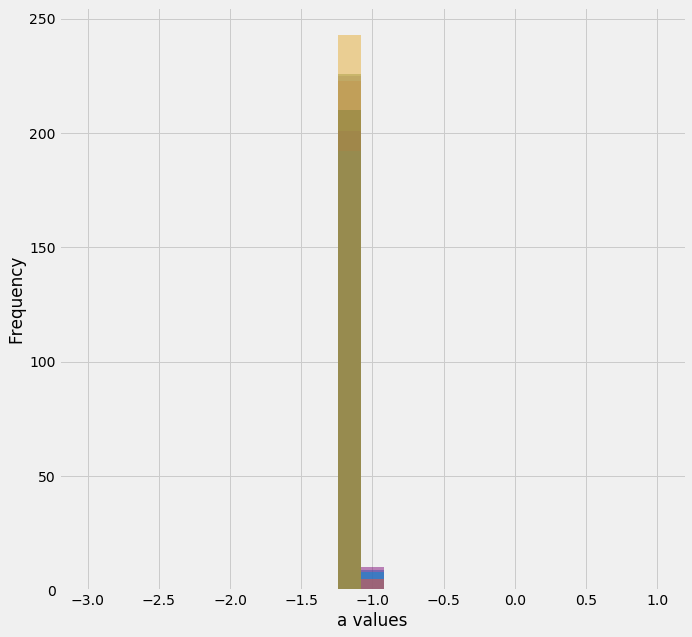

In [75]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i][950:2500], 25, range = (-3,1), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

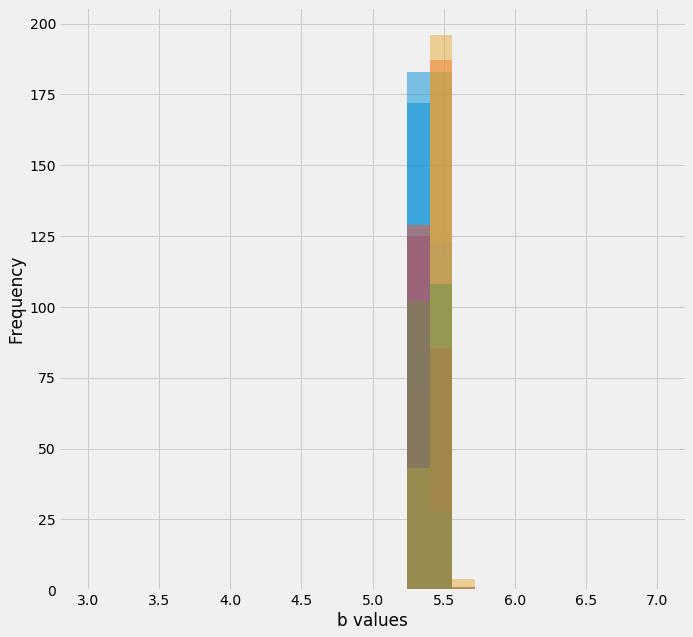

In [76]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i][950:2500], 25, range = (3,7), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

Quitamos el burning:

In [77]:
for i in range(10):
    a_total[i] = a_total[i][1000:2000]
    b_total[i] = b_total[i][1000:2000]

In [78]:
R(a_total, len(a_total[0]))

0.9989761619960469

In [79]:
R(b_total, len(b_total[0]))

1.0184839796170253

## **Agregamos un nuevo parámetro: parámetro de errores**

- Con un camino:

In [80]:
def function(x0, a0, b0):
    return a0*x0 + b0

def likelihood(a, b, f,data):
    equis = data[0]
    ye = data[1]
    yerr = data[2] 
    model = function(equis, a, b)
    likelihood_0 = (ye-model)**2/(yerr**2 + (f**2)*model**2)
    return likelihood_0.sum()

In [81]:
rango = 3000

a0 = -1
b0 = 4.0
f0 = 0.3
lnlike0 = -1*likelihood(a0, b0, f0,[x,y,yerror])

a_sample = [a0]
b_sample = [b0]
f_sample = [f0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    f_new = np.random.normal(f_sample[len(f_sample)-1], sigma)
    like = -1*likelihood(a_new, b_new, f_new, [x,y,yerror])
    if a_new <= -0.45 and a_new >= -1.45 and b_new <= 4.5 and b_new >= 3.5 and f_new <= 1 and f_new >= 0.2:
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
            f_sample.append(f_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
            f_sample.append(f_new)

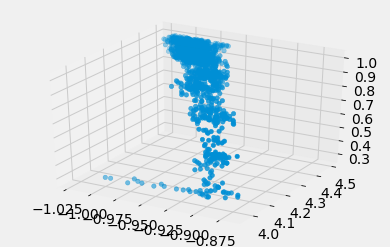

In [82]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

ax1.scatter(a_sample, b_sample, f_sample)


(array([  4.,   4.,  13.,  11.,  14.,  29.,  63.,  89., 158., 115.]),
 array([0.89304392, 0.90373648, 0.91442904, 0.92512159, 0.93581415,
        0.94650671, 0.95719927, 0.96789182, 0.97858438, 0.98927694,
        0.9999695 ]),
 <a list of 10 Patch objects>)

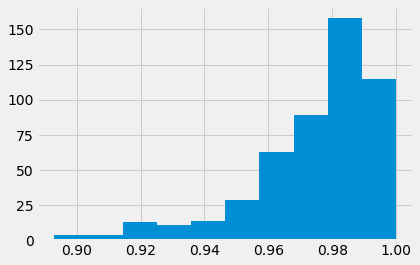

In [83]:
plt.hist(f_sample[1000:1500])

(array([ 74., 290., 486., 344., 205., 153.,  90.,  77.,  60.,  11.]),
 array([-1.02222889, -1.0065807 , -0.99093251, -0.97528433, -0.95963614,
        -0.94398795, -0.92833977, -0.91269158, -0.8970434 , -0.88139521,
        -0.86574702]),
 <a list of 10 Patch objects>)

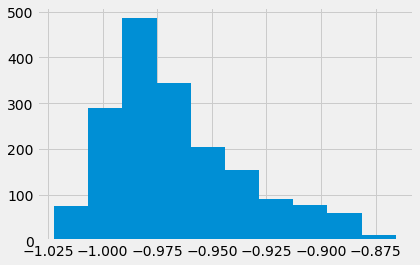

In [84]:
plt.hist(a_sample)

(array([ 85.,  40.,  23., 106.,  97., 117., 179., 331., 337., 475.]),
 array([3.95383402, 4.00843366, 4.0630333 , 4.11763294, 4.17223258,
        4.22683222, 4.28143186, 4.3360315 , 4.39063114, 4.44523078,
        4.49983042]),
 <a list of 10 Patch objects>)

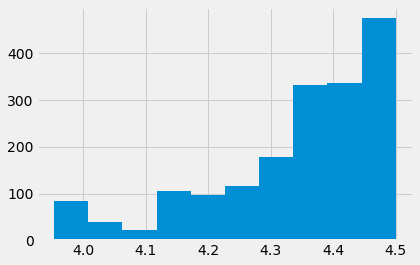

In [85]:
plt.hist(b_sample)

- Con varios caminos

In [105]:
a_total = []
b_total = []
f_total = []

sigma = 0.05
rango = 20000

for k in range(10):   
    a0 = np.random.normal(-0.5, 0.5, 10)
    b0 = np.random.normal(4, 0.5, 10)
    f0 = np.random.normal(0.3, 0.5, 10)
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    f_sample = [f0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], f0[k],[x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        f_new = np.random.normal(f_sample[len(f_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, f_new, [x,y,yerror])
        if a_new <= -0.45 and a_new >= -1.45 and b_new <= 4.5 and b_new >= 3.5 and f_new <= 1 and f_new >= 0.0:
            if like>lnlike0:
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
                f_sample.append(f_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)):
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
                f_sample.append(f_new)
    a_total.append(a_sample)
    b_total.append(b_sample)
    f_total.append(f_sample)

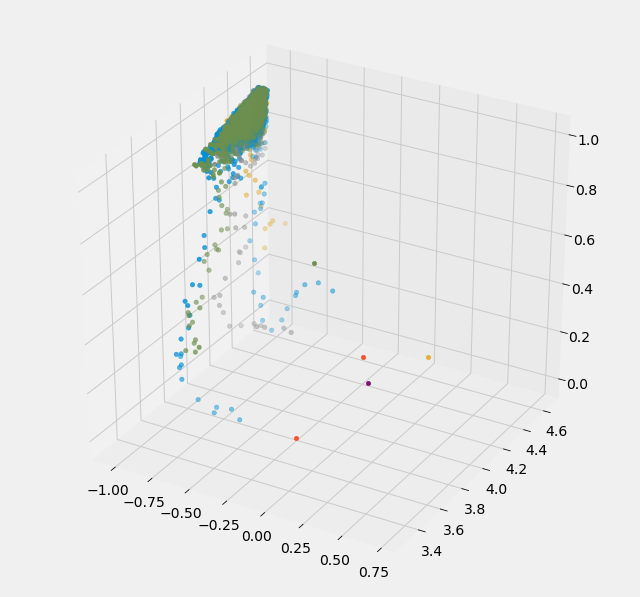

In [106]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111,projection='3d')

for i in range(10):
    ax1.scatter(a_total[i], b_total[i], f_total[i])

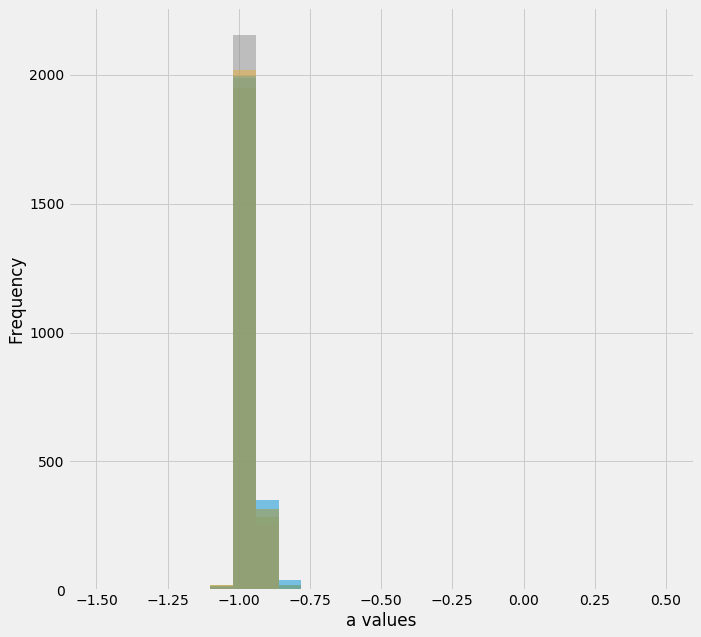

In [107]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i], 25, range = (-1.5, 0.5), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

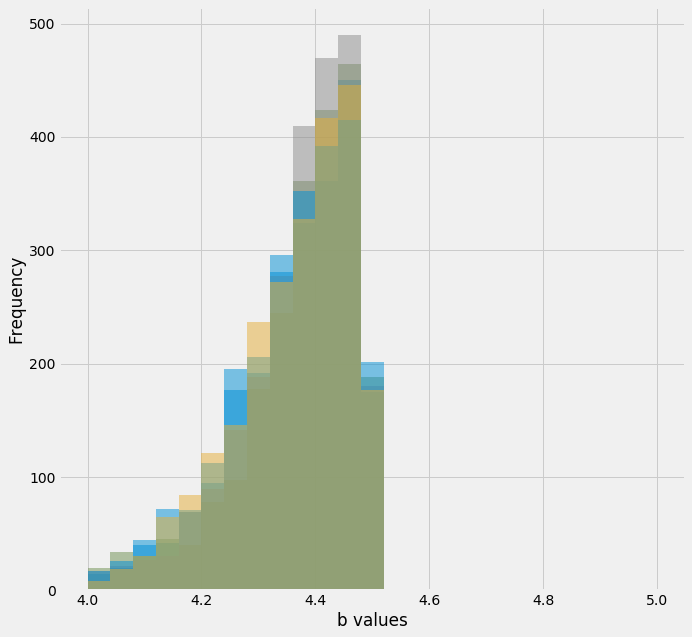

In [108]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i], 25, range = (4.0,5.0), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

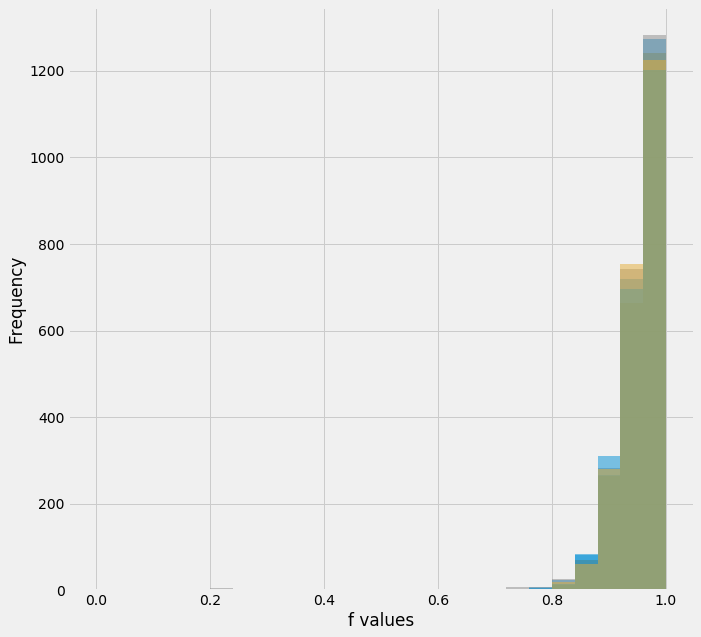

In [109]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(f_total[i], 25, range = (0.0,1.0), alpha=0.5);

plt.grid('True')
plt.xlabel('f values')
plt.ylabel('Frequency');

Quitamos el burning:

In [133]:
a_new = []
b_new = []
f_new = []

for i in range(10):
    if len(a_total[i])>=1000 and len(b_total[i])>=1000 and len(f_total[i])>=1000:
        a_new.append(a_total[i][1000:2000])
        b_new.append(b_total[i][1000:2000])
        f_new.append(f_total[i][1000:2000])

In [134]:
len(a_new)

5

In [136]:
n = len(a_new)
R(a_new,len(a_new[0]))

1.0000360736131315

In [137]:
R(b_new, len(b_new[0]))

1.00233621957614

In [138]:
R(f_new, len(f_new[0]))

0.9995426381614327

Notamos que sin el burning, los valores de R para cada parámetro son muy cercanos a uno.

- Calculamos medianas.

In [147]:
pendiente = np.median(a_new)

In [148]:
ordenada = np.median(b_new)

In [149]:
error = np.median(f_new)

In [150]:
np.mean(a_new)

-0.9718082068328425

In [151]:
np.mean(b_new)

4.367896843461463

In [152]:
np.mean(f_new)

0.9552144766342333

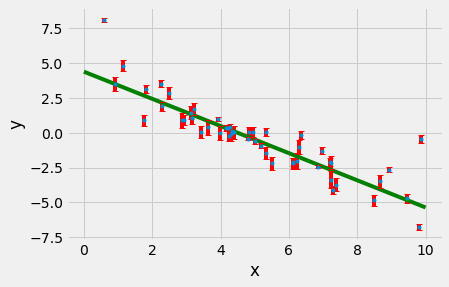

In [172]:
x_new = np.linspace(0,10,100)
y_new = x_new*pendiente + ordenada

plt.plot(x_new, y_new, '-g')
plt.errorbar(x, y,yerr = yerror, fmt = 'o', markersize = 3, ecolor = 'red', capsize = 3)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

Observamos la dispersión:

Text(0.5, 0, 'b')

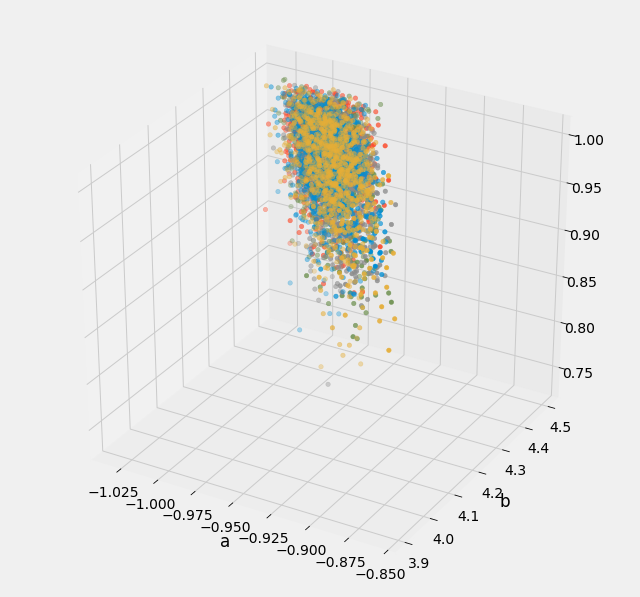

In [187]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(a_new)):
    ax1.scatter(a_new[i], b_new[i], f_new[i])
    
plt.xlabel('a')
plt.ylabel('b')

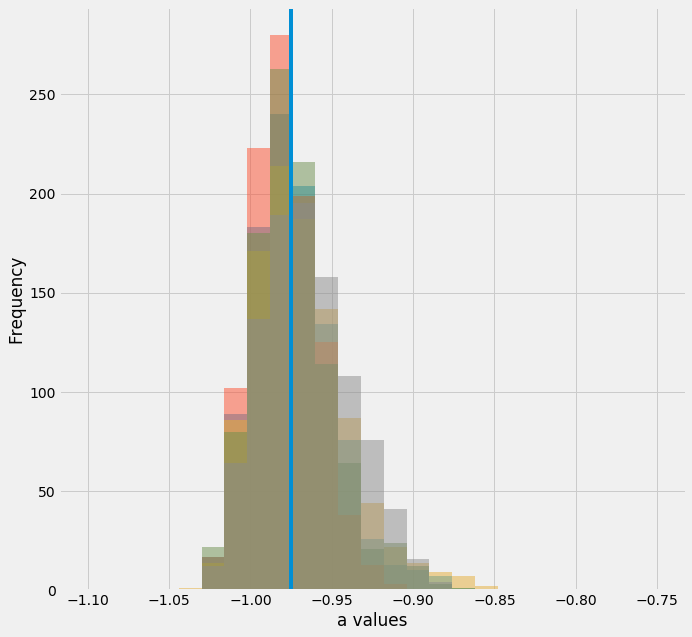

In [179]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(a_new[i], 25, range = (-1.1, -0.75), alpha=0.5);

plt.grid('True')
plt.axvline(pendiente)
plt.xlabel('a values')
plt.ylabel('Frequency');

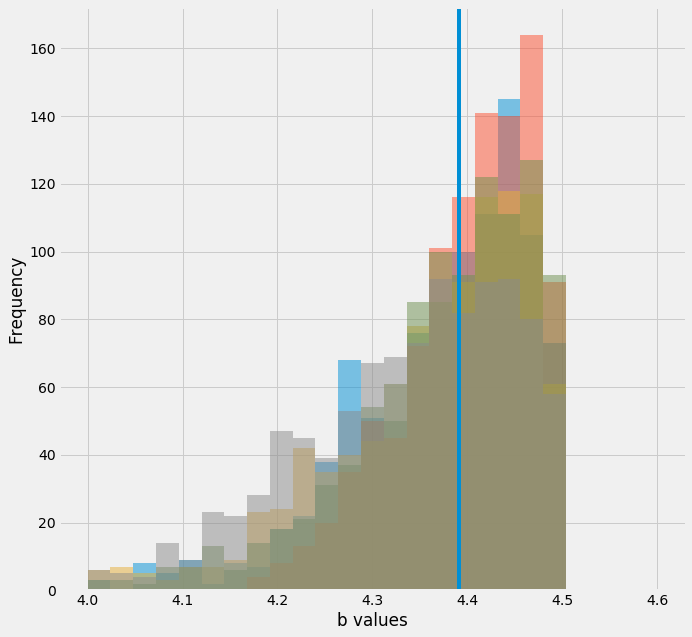

In [180]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(b_new[i], 25, range = (4, 4.6), alpha=0.5);

plt.grid('True')
plt.axvline(ordenada)
plt.xlabel('b values')
plt.ylabel('Frequency');

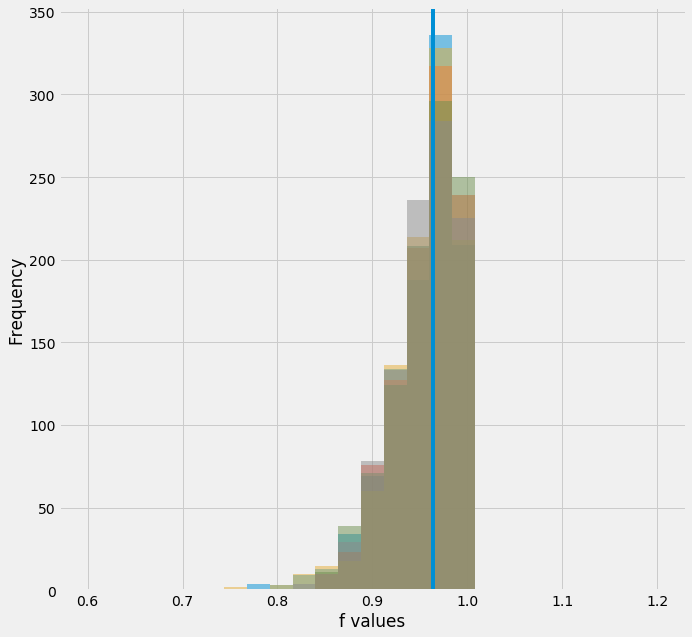

In [183]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(f_new[i], 25, range = (0.6, 1.2), alpha=0.5);

plt.grid('True')
plt.axvline(error)
plt.xlabel('f values')
plt.ylabel('Frequency');